In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from misc_tools.print_latex import print_tex
import torch, torch.nn as nn

input example : 
>>> arr_T = np.array([[r'\vec{v}_1', r'\vec{v}_2']]).T
>>> print_tex(arr_T,'=', np.arange(1,5).reshape(2,-1)/4, r'; symbols: \otimes, \cdot,\times')
output: 


<IPython.core.display.Math object>

paper: https://arxiv.org/pdf/1710.10903.pdf

Pre-reqs: Graph Convolutional Network (GNN_notes.ipynb)

Attention matrix replaces adjacency matrix:

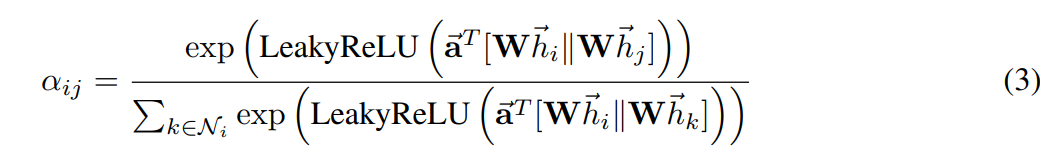

Pytorch source: https://nn.labml.ai/graphs/gat/index.html

***
**NOTE**:

Pytorch works in transpose representation and solves transposed linear equations
$$y = x W^T \leftrightarrow \vec{y}^T = \vec{x}^T W^T \rightarrow $$
$$Y^T = X^TW^T \leftrightarrow  Y = WX$$
Vectors are defined in classic column representation, so is matrix $W$.
<br>
(https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
***
**NOTE 2**:

In the first part i describe single-head attention framework, where you simply replace adjacency matrix with attention matrix.

Second part reimplements steps with multi-head approach, where you calculate several attention matrices in paralell and combine them in the end.

I split it because multi-head adds additional dimension and its harder to follow.
***

## Node features $\vec{h}_i$
Each of $N$ nodes nodes is described by a feature vector $\vec{h}_i$
$$\vec{h}_i \in \R^{F \times 1}, \ i \in \{1,2,\dots,N\}$$
Each feature is packed into matrix $H$
$$H=
\begin{bmatrix}
\vec{h}_1 & \vec{h}_2 & \dots
\end{bmatrix}^T=
\begin{bmatrix}
\vec{h}_1^T \\ \vec{h}_2^T \\ \vdots
\end{bmatrix}
\in \R^{N \times F}
$$

**NOTE**: it would be nice to call $H$ as $H^T$, but thats not consistent with pytorch implementation. Just remember that feature matrices are packed row vectors.

Have to do 'mental gymnastics' each time, but i hope calculated examples will help.

In [2]:
N_NODES,N_FEATS = 3,2
H_L     = 0.5*torch.arange(N_NODES*N_FEATS, dtype = float).view(N_NODES, N_FEATS)
H       = H_L.numpy()
# H[i] is a row of a matrix as a list. i want to extract list-rows ans columns

hs = H_L.unsqueeze(-1).numpy() # (2,2) -> (2,2,1); h1 -> H[i].reshape(-1,1) #h1, h2  
print_tex('H = ', H) 

prntH = []
for i,h in enumerate(hs):
    prntH.append(r'\vec{h}_'+str(i) +'^T = ')
    prntH.append(h.reshape(1,-1))
    prntH.append('; \\ ')

print_tex(*prntH)

<IPython.core.display.Math object>

<IPython.core.display.Math object>


## Node feature projection $\vec{g}_i = W \vec{h}_i$ onto $F^\prime$ space
Each feature $\vec{h}_i$ is mapped to a lower dimension $F^\prime$ as $\vec{g}_i$ (w/o activation)
$$\vec{g}_i \in \R^{F^\prime \times 1}, \ i \in \{1,2,\dots,N\}$$
$$\vec{g}_i^T = \vec{h}_i^T W^T  \rightarrow G = H W^T $$

$$G = 
\begin{bmatrix}
\vec{g}_1 &
\vec{g}_2 & \dots
\end{bmatrix}^T
\in \R^{N \times F^\prime}
$$

For simplicity lets keep $F = F^\prime$ and make $W$ a scaling transformation

In [3]:
# define lin transform as a NN Layer. Maps F to F'. Scaling by factor of 2.
W_L = nn.Linear(in_features=N_FEATS, out_features=N_FEATS, bias=False, dtype=H_L.dtype)
with torch.no_grad():
    # NOTICE that wight matrix is returned as W, not as W^T. it will be more clear later with non-symmetric W.
    W_L.weight[:] = 2*torch.eye(N_FEATS)    # strangely [:] works here, and w/o does not
    W = W_L.weight.clone().numpy()

# apply map to H.
G_L = W_L(H_L)
G = G_L.detach().numpy()
gs = G_L.unsqueeze(-1).detach().numpy()

print_tex('G = HW^T = ', H, W.T, ' = ', G)

prntG = []
for i,g in enumerate(gs):
    prntG.append(r'\vec{g}_'+str(i) +'^T = ',)
    prntG.append(g.reshape(1,-1))
    prntG.append('; \\ ')

print_tex(*prntH)
print_tex(*prntG)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Attention mechanism
### Feature concatenation $\vec{g}_i||\vec{g}_j$
Attention mechanism sets a weight of an edge based on their features.
* Create a matrix $C$ that stores each pair of concatenated features;
* Ordering is the same as with adjacency matrix.
* $C$ contains transposed entries, like $H$ and $G$ (for nn.Linear())

$$C = 
\begin{bmatrix}
\vec{g}_1^T||\vec{g}_1^T &  \vec{g}_1^T||\vec{g}_2^T \\
\vec{g}_2^T||\vec{g}_1^T &  \vec{g}_2^T||\vec{g}_2^T
\end{bmatrix}
$$
cannot broadcast, have to concat all elements. If we flatten:
$$C_{flat} = 
\begin{bmatrix}
\vec{g}_1^T||\vec{g}_1^T \\  \vec{g}_1^T||\vec{g}_2^T \\
\vec{g}_2^T||\vec{g}_1^T \\  \vec{g}_2^T||\vec{g}_2^T
\end{bmatrix}
\approx

\begin{bmatrix}
\vec{g}_1^T \\  \vec{g}_1^T \\
\vec{g}_2^T \\  \vec{g}_2^T \\
\end{bmatrix} 
\Bigg|\Bigg|
\begin{bmatrix}
\vec{g}_1^T \\  \vec{g}_2^T \\
\vec{g}_1^T \\  \vec{g}_2^T \\
\end{bmatrix}

$$ 

So its element-wise concat. Observe ordering of both vectors. 

In [4]:
g_left      = torch.repeat_interleave(G_L, N_NODES, dim = 0) 
g_right     = G_L.repeat(N_NODES,1)                         
C_f         = torch.cat((g_left,g_right), dim = 1)

print_tex(*prntG)
print_tex(r'C_{left} = ',g_left.detach().numpy(), r'C_{right} = ',g_right.detach().numpy())
print_tex(r'C_{flat} = C_{left}||C_{right}= ',C_f.detach().numpy())
print_tex(r'C_{flat}[1] = \vec{g}_1^T||\vec{g}_1^T = ', C_f[0].detach().numpy())
print_tex(r'C_{flat}[2] = \vec{g}_1^T||\vec{g}_2^T = ', C_f[1].detach().numpy())

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Feature pair projection $e_{i,j} $ 

Next, reduce feature pair into a scalar via attention vector $\vec{a}$, which can be applied via nn.Linear() that reduces $2F^\prime \rightarrow 1$

$$\bigg[e_{i,j} = (\vec{g}_i||\vec{g}_j)^T \vec{a} = (\vec{g}_i||\vec{g}_j)^T W_a^T\bigg] \leftrightarrow \bigg[\vec{x}^T W^T = \vec{y}^T\bigg]$$
or packed into matrix-matrix multiplication

$$E = C_{flat} W_a^T = C W_a^T$$

For simplicity lets consider $\vec{a} = W_a^T$ that summs all elements of feature pair

In [5]:
attention = nn.Linear(2*N_FEATS, 1, bias=False, dtype = G_L.dtype)
with torch.no_grad():
    Wa = attention.weight[:] = torch.ones_like(attention.weight[:])
    x,y = torch.tensor(Wa.shape).numpy()
    print_tex('W_a = ', Wa.detach().numpy(), '; shape = [', x, r'\times', y, ']')


<IPython.core.display.Math object>

It is better if we reshape C into shape of $[N \times N ]$ to conform with adjacency matrix.

Shape of $W_a$ is set by nn.Linear()

So for layer's equation 
$$E = C W^T: [N \times N  \times 2F^\prime]\times [2F^\prime \times 1] = [N  \times N \times 1] $$

Followed by flattening of 3rd dimension.

In [6]:
C = C_f.reshape(N_NODES, N_NODES, 2*N_FEATS)
C2 = C.detach().numpy()
E0 = attention(C).squeeze(-1)
E02 = E0.detach().numpy()
[print_tex('C_{' + f'{i},{j}' + '} = ', C2[i,j], '; e_{' + f'{i},{j}' + '} = ', E02[i,j]) for i in range(N_NODES) for j in range(N_NODES)];
print_tex('E0 = ', E0.detach().numpy())

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Apply ReLU (trivial here)

In [7]:
activation = nn.ReLU(0.2)
E = activation(E0)
print_tex('E = \sigma(E0) = ', E.detach().numpy())

<IPython.core.display.Math object>

### Edge weight masking
Apply masking via adjacency matrix.

* make adjacency matrix thats symmetric and has 0 diag
* apply masking. since we are taking a softmax $e^x$, masking should be done by setting $x\rightarrow -\infty: e^{-\infty} = 0$ 

In [8]:

torch.manual_seed(2)
rand = torch.randint(0,2,size=E.shape)
A = torch.triu(rand, 1) + torch.triu(rand, 1).T
print_tex('A = ', A.numpy())
E = E.masked_fill(A == 0, float('-inf'))
print('E = \n', E.detach().numpy())

<IPython.core.display.Math object>

E = 
 [[-inf   6.  10.]
 [  6. -inf  14.]
 [ 10.  14. -inf]]


In [9]:
softmax = nn.Softmax(dim = 1)
alpha = softmax(E)
print_tex(r'\alpha = ', alpha.detach().numpy())

<IPython.core.display.Math object>

## Graph feature update
Classic GCN calculates feature update as following
$$H_{new} = \sigma( D^{-\frac{1}{2}} \tilde A D^{-\frac{1}{2}} H W_h + \vec{b_h})$$

Where $D^{-\frac{1}{2}} \tilde A D^{-\frac{1}{2}}$ is a normalized adjacency matrix

We replace it with attention matrix:
$$H_{new} = \sigma( \alpha H W_h + \vec{b_h})$$

## Multi-head attention

It is possible to apply multiple ($K$) independent attention variants in parallel.


\begin{cases}
\ k \in \{1,\dots, K\} \\
\vec{g}_i^k = W^k \vec{h}_i \\
e_{i,j}^k = {\vec{a}^k}^T (\vec{g}_i^k||\vec{g}_j^k) \\
\alpha^k = {Softmax}(e_{i,j}^k)
\end{cases}
Definition is bit more difficult, but can be explained by expanding OG matrices.

Input data stay the same
$$H=
\begin{bmatrix}
\vec{h}_1 & \vec{h}_2 & \dots
\end{bmatrix}^T=
\begin{bmatrix}
\vec{h}_1^T \\ \vec{h}_2^T \\ \vdots
\end{bmatrix}
\in \R^{N \times F}
$$

**Define**: ${\vec{g}_{i}^k}$ as feature vector $\vec{g}$ for node $i$ and head $k$

New weight matrix $W_K$ is a vertical concatenation of K different $W_k$ matrices (when view from default left-multiply perspective).
$$
{\vec{g}_{i}^k}= W_K \vec{h}_i  =
\begin{bmatrix}
W_1 \\\hline\hline W_2
\end{bmatrix}
\vec{h}_i=
\begin{bmatrix}
\vec{h}_i W_1 \\\hline\hline \vec{h}_i W_2
\end{bmatrix}=
\begin{bmatrix}
\vec{g}_{i}^1 \\\hline\hline \vec{g}_{i}^2
\end{bmatrix}
$$

Or when viewed from right-multiply perspective (nn.Linear)
$$
{\vec{g}_{i}^k}^T = 
\vec{h}_i^T
W_K^T = 
\vec{h}_i^T
\begin{bmatrix}
W_1 \\\hline\hline W_2
\end{bmatrix}^T=
\vec{h}_i^T
\begin{bmatrix}
W_1^T ||W_2^T
\end{bmatrix}=
\begin{bmatrix}
\vec{h}_i^T W_1^T || \vec{h}_i^TW_2^T
\end{bmatrix}=

\begin{bmatrix}
{\vec{g}_i^1}^T || {\vec{g}_i^2}^T
\end{bmatrix}
\rightarrow
$$
Packed into matrices $H$ and $G_K$
$$
G_K =  
H W_K^T=
H
\begin{bmatrix}
W_1 \\\hline\hline W_2
\end{bmatrix}^T=
H
\begin{bmatrix}
W_1^T || W_2^T
\end{bmatrix} = 
\begin{bmatrix}
H W_1^T || H W_2^T
\end{bmatrix} = 
\begin{bmatrix}
G_1 || G_2
\end{bmatrix}
$$

For example lets consider that K = 2 and two concatenated matrices that scale original feature vectors by 2 and 4.

In [10]:
N_HEADS = 2
Wk_L = nn.Linear(N_FEATS, N_HEADS*N_FEATS, bias=False, dtype=H_L.dtype)
scale2 = 2*torch.eye(N_FEATS)
scale4 = 4*torch.eye(N_FEATS)
with torch.no_grad():
    Wk_L.weight[:N_FEATS] = scale2
    Wk_L.weight[N_FEATS:] = scale4
    Wk = Wk_L.weight.clone().numpy()

print('1) Test scaling separately')
g1 = H @ scale2.T.numpy()
g2 = H @ scale4.T.numpy()
print_tex('H = ', H,'; W_1 = ', Wk[:N_FEATS], '; W_2 = ', Wk[N_FEATS:])
print_tex('G_1 = H W_1^T = ', g1 , '; \ G_2 =H W_2^T = ', g2)
print('2) Test scaling concatenated')
Gk_L = Wk_L(H_L)
GK2 = Gk_L.detach().numpy()
print_tex('W_K=',Wk, '; G = H W_K^T = ', GK2, '= G_1||G_2')

1) Test scaling separately


<IPython.core.display.Math object>

<IPython.core.display.Math object>

2) Test scaling concatenated


<IPython.core.display.Math object>

Recap:

$G_K$ consists of concatenated transformed input features 

$$G_K=
\begin{bmatrix}
H W_1^T || H W_2^T
\end{bmatrix}=
\begin{bmatrix}
G_1 || G_2
\end{bmatrix}=
\begin{bmatrix}
    \begin{matrix}
    {\vec{g}_{1}^{1}}^T \\
    {\vec{g}_{2}^{1}}^T
    \end{matrix}
    
    \Bigg|\Bigg|
    \begin{matrix}
    {\vec{g}_{1}^{2}}^T \\
    {\vec{g}_{2}^{2}}^T
    \end{matrix}
\end{bmatrix}
$$
It is still a structure thats ordered by index of a node $[N \times 2F^\prime]$




Split concatenated head features by reshaping $G_K$ to $[N_{nodes} \times N_{heads} \times  F^\prime]$ 

**NOTE**: 

<u>Removed transpose for clarity, 3rd dimension is no longer a row nor a column. </u>

$$
G_{K,reshape}=
\begin{bmatrix} 
G_1 \\ G_2
\end{bmatrix}=
\begin{bmatrix} 
    \begin{bmatrix} 
    \vec{g}_{1}^{k1} &
    \vec{g}_{1}^{k2}
    \end{bmatrix} 
    \\
    \begin{bmatrix} 
    \vec{g}_{2}^{k1} &
    \vec{g}_{2}^{k2}
    \end{bmatrix}
\end{bmatrix}
$$


In [11]:
Gk_reshape = Gk_L.reshape(N_NODES, N_HEADS, N_FEATS)
#print_tex(Gk_reshape[:,[0]].reshape(N_NODES, N_FEATS).detach().numpy())




We want same structure as in 1-head-case:
$$C=
\begin{bmatrix}
\vec{g}_1^T||\vec{g}_1^T \\  \vec{g}_1^T||\vec{g}_2^T \\
\vec{g}_2^T||\vec{g}_1^T \\  \vec{g}_2^T||\vec{g}_2^T
\end{bmatrix}
$$
Except for additional 2nd dimension for different heads.

$$
C_K = 
\begin{bmatrix}
    \begin{bmatrix}
        \vec{g}_{1}^{k1}||\vec{g}_{1}^{k1} & \vec{g}_{1}^{k2}||\vec{g}_{1}^{k2}
    \end{bmatrix}
    \\ 
    \begin{bmatrix}
        \vec{g}_{1}^{k1}||\vec{g}_{2}^{k1} & \vec{g}_{1}^{k2}||\vec{g}_{2}^{k2}
    \end{bmatrix}
    \\
    \begin{bmatrix}
        \vec{g}_{2}^{k1}||\vec{g}_{1}^{k1} & \vec{g}_{2}^{k2}||\vec{g}_{1}^{k2}
    \end{bmatrix}
    \\ 
    \begin{bmatrix}
        \vec{g}_{2}^{k1}||\vec{g}_{2}^{k1} & \vec{g}_{2}^{k2}||\vec{g}_{2}^{k2}
    \end{bmatrix}
\end{bmatrix}
\approx
\begin{bmatrix}
    \begin{bmatrix}
        \vec{g}_{1}^{k1} & \vec{g}_{1}^{k2}
    \end{bmatrix}
    \\ 
    \begin{bmatrix}
        \vec{g}_{1}^{k1} & \vec{g}_{1}^{k2}
    \end{bmatrix}
    \\
    \begin{bmatrix}
        \vec{g}_{2}^{k1} & \vec{g}_{2}^{k2}
    \end{bmatrix}
    \\ 
    \begin{bmatrix}
        \vec{g}_{2}^{k1} & \vec{g}_{2}^{k2}
    \end{bmatrix}
\end{bmatrix}
\Bigg|\Bigg|
\begin{bmatrix}
    \begin{bmatrix}
        \vec{g}_{1}^{k1} & \vec{g}_{1}^{k2}
    \end{bmatrix}
    \\ 
    \begin{bmatrix}
        \vec{g}_{2}^{k1} & \vec{g}_{2}^{k2}
    \end{bmatrix}
    \\
    \begin{bmatrix}
        \vec{g}_{1}^{k1} & \vec{g}_{1}^{k2}
    \end{bmatrix}
    \\ 
    \begin{bmatrix}
        \vec{g}_{2}^{k1} & \vec{g}_{2}^{k2}
    \end{bmatrix}
\end{bmatrix}
$$

You may see that  left matrix contains repeated rows of $G_{K,reshape}$ and right matrix is formed from interleaved rows.

In [12]:
CK_left = Gk_reshape.repeat_interleave(N_NODES, dim=0)

prnt = []

for i in range(N_NODES):
    prnt.append(r'\vec{g}_1^{k'+str(i) + '}= ')
    prnt.append(g1[i].reshape(1,-1))
    prnt.append(f'; \ ')

print_tex(*prnt)
#print_tex(r'\vec{g}_{1}^{k1}=', g11, r'\vec{g}_{1}^{k2}=', g12)
print_tex(r'Repeat_{flat} \ (K=1): ',CK_left[:,[0]].squeeze(1).detach().numpy())


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [13]:
Ck_right = Gk_reshape.repeat(N_NODES, 1, 1);
print_tex('Interleave_{flat} \ (K=1): ',Ck_right[:,[0]].squeeze(1).detach().numpy())

<IPython.core.display.Math object>

In [14]:
Ck_flat = torch.cat([CK_left, Ck_right], dim=-1);
print_tex('G_{flat} \ (K=1): ',Ck_flat[:,[0]].squeeze(1).detach().numpy())

<IPython.core.display.Math object>

Reshape it into $[N \times N \times N_{heads} \times 2F]$ matrix that can be broadcasted with adjacency matrix

In [15]:
Ck = Ck_flat.view(N_NODES, N_NODES, 2, 2*N_FEATS);
Ck.shape

torch.Size([3, 3, 2, 4])

View two feature pairs for node1-node1 interaction

In [16]:
Ck[0,0]

tensor([[0., 1., 0., 1.],
        [0., 2., 0., 2.]], dtype=torch.float64, grad_fn=<SelectBackward0>)

calculate projections (again we reuse old layer with dot that fives a sum of elements)

In [17]:
Ek0 = activation(attention(Ck)).squeeze(-1);Ek0[0,0]

tensor([2., 4.], dtype=torch.float64, grad_fn=<SelectBackward0>)

In [18]:
Ek0.shape, A.shape

(torch.Size([3, 3, 2]), torch.Size([3, 3]))

Repeat masking. Added 1 dimension to A so its broadcastable to heads.

In [19]:
Ek0.shape, A.shape

(torch.Size([3, 3, 2]), torch.Size([3, 3]))

In [20]:
print_tex('A = ', A.numpy())
Ek = Ek0.masked_fill(A.view(N_NODES,N_NODES,1) == 0, float('-inf'))
#print('E = \n', Ek.detach().numpy())
for k in range(N_HEADS):
    print(f'E_'+str(k)+' = \n', Ek[:,:,k].detach().numpy())


<IPython.core.display.Math object>

E_0 = 
 [[-inf   6.  10.]
 [  6. -inf  14.]
 [ 10.  14. -inf]]
E_1 = 
 [[-inf  12.  20.]
 [ 12. -inf  28.]
 [ 20.  28. -inf]]


In [21]:
alphak = softmax(Ek)
[print_tex(r'\alpha_'+str(k)+'= ', alphak[:,:,k].detach().numpy()) for k in range(N_HEADS)];

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Result of shape (N_nodes, N_heads, N_features)

In [22]:
res = torch.einsum('ijh,jhf->ihf', alphak, Gk_reshape);
print(res.detach().numpy(), res.shape)

[[[3.96402758 4.96402758]
  [7.9986586  9.9986586 ]]

 [[3.9986586  4.9986586 ]
  [7.9999991  9.9999991 ]]

 [[1.96402758 2.96402758]
  [3.9986586  5.9986586 ]]] torch.Size([3, 2, 2])
